# Solution by Tencent Quantum Lab
The key points of the solution
- Ansatz Construction. Use hardware efficient $R_y$ ansatz to achieve extremely shallow circuit depth and short circuit duration
- Pauli Operator Grouping. Eliminate Pauli operators based on chemical heuristics.
- Error mitigation. Simple yet effective error mitigation with very little measurement overhead.

## Building the Parameterized Quantum Circuit

In [1]:
from qiskit.providers.fake_provider import FakeMontreal
system_model = FakeMontreal()

In [2]:
from qiskit import transpile, pulse, QuantumCircuit
from qiskit.circuit import ParameterVector

In [3]:
n_qubits = 12
n_layers = 1
c = QuantumCircuit(n_qubits)
pv = ParameterVector("p", (n_layers + 1) * n_qubits)
# R_y circuit with linear qubit connectivity and parallel CNOTs
for i in range(n_qubits):
    c.ry(pv[i], i)
for j in range(n_layers):
    assert n_qubits % 2 == 0
    for i in range(n_qubits // 2):
        c.cnot(2*i, 2*i+1)
    for i in range(n_qubits // 2 - 1):
        c.cnot(2*i+1, 2*i+2)
    for i in range(n_qubits):
        c.ry(pv[(j+1)*n_qubits + i], i)
# these indices ensures that when all parameters are set to 0, the output state is the HF state 001111001111
for i in [2, 3, 4, 5, 8, 9, 10, 11]:
    c.x(i)
c = transpile(c, backend=system_model)
c.draw(fold=400)

ancilla_0 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────
                 ┌────┐ ┌──────────────┐┌────┐┌────────┐     ┌────┐┌───────────────┐      ┌────┐     ┌────────┐          
        q_0 -> 1 ┤ √X ├─┤ Rz(p[0] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ √X ├┤ Rz(p[12] + π) ├──────┤ √X ├─────┤ Rz(3π) ├──────────
                 ├────┤ ├──────────────┤├────┤├────────┤┌─┴─┐└────┘└─────┬────┬────┘┌─────┴────┴────┐└─┬────┬─┘┌────────┐
        q_1 -> 2 ┤ √X ├─┤ Rz(p[1] + π) ├┤ √X ├┤ Rz(3π) ├┤ X ├──■─────────┤ √X ├─────┤ Rz(p[13] + π) ├──┤ √X ├──┤ Rz(3π) ├
                 ├────┤ ├──────────────┤├────┤├────────┤└───┘┌─┴─┐       ├────┤     ├───────────────┤┌─┴────┴─┐└─┬────┬─┘
        q_2 -> 3 ┤ √X ├─┤ Rz(p[2] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ X ├───────┤ √X ├─────┤ Rz(p[14] + π) ├┤ Rz(-π) ├──┤ √X ├──
                 └────┘ └──────────────┘└────┘└────────┘  │  └───┘       └────┘     └───────────────┘└────────┘  └────┘  
  ancilla_1 -> 4 ─────────────────────────────────────────┼──────────────────────────────────────────────────────────────
                 ┌────┐ ┌──────────────┐┌────┐┌────────┐┌─┴─┐            ┌────┐     ┌───────────────┐┌────────┐  ┌────┐  
        q_3 -> 5 ┤ √X ├─┤ Rz(p[3] + π) ├┤ √X ├┤ Rz(3π) ├┤ X ├──■─────────┤ √X ├─────┤ Rz(p[15] + π) ├┤ Rz(-π) ├──┤ √X ├──
                 └────┘ └──────────────┘└────┘└────────┘└───┘  │         └────┘     └───────────────┘└────────┘  └────┘  
  ancilla_2 -> 6 ──────────────────────────────────────────────┼─────────────────────────────────────────────────────────
                                                               │                                                         
  ancilla_3 -> 7 ──────────────────────────────────────────────┼─────────────────────────────────────────────────────────
                 ┌────┐ ┌──────────────┐┌────┐┌────────┐     ┌─┴─┐       ┌────┐     ┌───────────────┐┌────────┐  ┌────┐  
        q_4 -> 8 ┤ √X ├─┤ Rz(p[4] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ X ├───────┤ √X ├─────┤ Rz(p[16] + π) ├┤ Rz(-π) ├──┤ √X ├──
                 └────┘ └──────────────┘└────┘└────────┘  │  └───┘       └────┘     └───────────────┘└────────┘  └────┘  
  ancilla_4 -> 9 ─────────────────────────────────────────┼──────────────────────────────────────────────────────────────
                                                          │                                                              
 ancilla_5 -> 10 ─────────────────────────────────────────┼──────────────────────────────────────────────────────────────
                 ┌────┐ ┌──────────────┐┌────┐┌────────┐┌─┴─┐            ┌────┐     ┌───────────────┐┌────────┐  ┌────┐  
       q_5 -> 11 ┤ √X ├─┤ Rz(p[5] + π) ├┤ √X ├┤ Rz(3π) ├┤ X ├──■─────────┤ √X ├─────┤ Rz(p[17] + π) ├┤ Rz(-π) ├──┤ √X ├──
                 └────┘ └──────────────┘└────┘└────────┘└───┘  │         └────┘     └───────────────┘└────────┘  └────┘  
 ancilla_6 -> 12 ──────────────────────────────────────────────┼─────────────────────────────────────────────────────────
                                                               │                                                         
 ancilla_7 -> 13 ──────────────────────────────────────────────┼─────────────────────────────────────────────────────────
                 ┌────┐ ┌──────────────┐┌────┐┌────────┐     ┌─┴─┐       ┌────┐     ┌───────────────┐  ┌────┐  ┌────────┐
       q_6 -> 14 ┤ √X ├─┤ Rz(p[6] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ X ├───────┤ √X ├─────┤ Rz(p[18] + π) ├──┤ √X ├──┤ Rz(3π) ├
                 └────┘ └──────────────┘└────┘└────────┘  │  └───┘       └────┘     └───────────────┘  └────┘  └────────┘
 ancilla_8 -> 15 ─────────────────────────────────────────┼──────────────────────────────────────────────────────────────
                 ┌────┐ ┌──────────────┐┌────┐┌────────┐┌─┴─┐            ┌────┐     ┌───────────────┐  ┌────┐  ┌────────┐
       q_7 -> 16 ┤ √X ├─┤ Rz(p[7] + π) ├┤ √X ├┤ Rz(3π) ├┤ X ├──■─────────┤ √X ├─────┤ Rz(p[19] + π

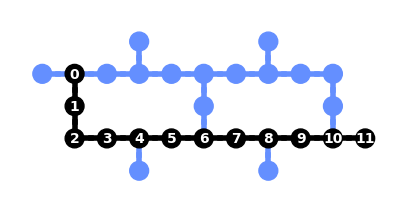

In [4]:
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(c, system_model)

In [5]:
# obtain the duration. 
# No transpilation happens after binding the parameters so this is the final circuit and duration
with pulse.build(system_model) as my_program1:
    with pulse.transpiler_settings(optimization_level=0):
        pulse.call(c)
my_program1.duration

5024

## Obtain the Hamiltonian as QubitOperator
Use TenCirChem to obtain the qubit operators with Jordan-Wigner transformation.
Do not use the operators provided in the official GitHub repo because I'm more familiar with the convention in TenCirChem (in terms of the orbital ordering, etc.)

In [6]:
import numpy as np

from tencirchem import M, UCC

from qiskit.quantum_info import SparsePauliOp, Pauli

ultra_simplified_ala_string = """
O 0.0 0.0 0.0
H 0.45 -0.1525 -0.8454
"""
m = M(atom=ultra_simplified_ala_string, charge=1)
ucc = UCC(m, init_method="zero", run_mp2=False, run_ccsd=False)

In [7]:
# total number of terms is 631
len(ucc.h_qubit_op.terms)

631

## Group and Simplify the Pauli Operators

The ground state wavefunction of chemical systems is usually dominated by the HF state. This can be exploited to reduce the number of terms in the Hamitlonian. More specifically, we may combine terms such as $XX$ and $YY$ because they may have the same expectation value (up to a phase).
This simplification is not exact, but as shown below the accuracy is satisfactory.

Another benefit of the method is that it significantly reduces the number of terms that do not commute, which will be shown below.

In [8]:
# Check if we can merge the two Pauli strings.
# The criteria is that, assume X and Y are the same symbol, the two Pauli strings are identical.
# The terms that can be combined are successive in the operator list, which can be inspected with `ucc.h_qubit_op.terms`
def is_from_same_term(k1, k2):
    # input example: k1: ((4, 'Y'), (5, 'Y'), (8, 'Z')) ((4, 'Y'), (5, 'Y'), (7, 'Z'))
    #                k2: ((4, 'Y'), (5, 'Y'), (8, 'Z')) ((4, 'X'), (5, 'X'), (7, 'Z'))
    if len(k1) != len(k2):
        return False
    for t1, t2 in zip(k1, k2):
        if t1[0] != t2[0]:
            return False
        if t1[1] != t2[1]:
            if set([t1[1], t2[1]]) != {"X", "Y"}:
                return False
    return True

In [9]:
target_state = "001111001111"
# Get the phase after acting the Pauli string on the target HF state
def get_phase(k):
    phase = 1
    for i, symbol in k:
        if symbol == "Z":
            continue
        elif symbol == "X":
            continue
        elif symbol == "Y":
            if target_state[i] == "0":
                phase *= 1j
            else:
                phase *= -1j
        else:
            assert False
            
    assert phase.imag == 0
    return phase.real

In [10]:
# Combine terms in the Hamiltonian
ks = []
vs = []
for k, v in ucc.h_qubit_op.terms.items():
    ks.append(k)
    vs.append(v)
new_ks = []
new_vs = []
while len(ks) != 0:
    # take the first term as the reference
    k_ref = ks[0]
    v_ref = vs[0]
    # three different cases: 0/2/4 operators can be combined
    stride = 1
    if len(vs) > 1 and is_from_same_term(ks[1], k_ref):
        stride = 2
        if len(vs) > 2 and is_from_same_term(ks[2], k_ref):
            assert is_from_same_term(ks[3], k_ref)
            stride = 4
    # summing up the coefficients
    new_v = v_ref
    phase_ref = get_phase(k_ref)
    for i in range(1, stride):
        k = ks[i]
        v = vs[i]
        new_v += phase_ref * get_phase(k) * v
    new_ks.append(k_ref)
    new_vs.append(new_v)
    ks = ks[stride:]
    vs = vs[stride:]

In [11]:
# the number of terms after the reduction
len(new_ks)

284

In [12]:
# prepare conversion to Qiskit format for energy estimation
pauli_list = []
coeffs_list = []
for k, v in zip(new_ks, new_vs):
    s = ["I"] * 12
    for i, symbol in k:
        s[n_qubits-1-i] = symbol
    s = "".join(s)
    pauli_list.append(s)
    coeffs_list.append(v)

In [13]:
# convert the Hamiltonian operator into Qiskit format
# take care of the mapping from virtual operators to physical qubits since the operators are 12 qubits but the circuit is 27 qubits
virtual_bit_map = c.layout.initial_layout.get_virtual_bits()
mapping = {q._index: i for q, i in virtual_bit_map.items() if q._register.name == "q"}
new_pauli_list = []
for s in pauli_list:
    assert len(s) == n_qubits
    new_s = ["I"] * 27
    for i, symbol in enumerate(s[::-1]):
        new_i = system_model.configuration().n_qubits - 1 - mapping[i]
        # print(i, new_i, symbol)
        new_s[new_i] = symbol
    new_pauli_list.append("".join(new_s))
qubit_op = SparsePauliOp(new_pauli_list, coeffs=coeffs_list)
# eliminate terms that have small coefficients. This is an approximation with reasonable accuracy.
qubit_op = qubit_op.chop(1e-2)
# the final number of terms
len(qubit_op)

141

In [14]:
# The number of mesurement groups during measurement
len(qubit_op.group_commuting(qubit_wise=True))

20

## Estimate the Energy

In [15]:
# pre-optimized parameters
params = np.array([-2.03398892e-04, -4.15622035e-04, -7.24161680e-05, 1.09710025e-04,
  1.31789033e-05, -3.40277090e-06,  7.24185393e-04,-4.91700987e-01,
  8.81924698e-05,  8.16163577e-05, -4.51390009e-06, 4.37765082e-02,
  5.55411728e-04,  3.14232489e+00, -1.32248519e-03, 2.55558786e-05,
  3.84389308e-04, -2.82906559e-05,  3.22800688e-04, 1.12892004e-03,
 -4.88599954e-04,  2.99351879e-04, -1.88525987e-04,-4.37794871e-02,])

In [16]:
# params for error mitigation
params_em = np.zeros_like(params)

In [17]:
# we use the same circuit for all three different noise models
c1 = c.bind_parameters(params)
c2 = c.bind_parameters(params_em)
c1.qasm(filename="circuit.txt")
c2.qasm(filename="circuit_em.txt")

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[27];\nsx q[1];\nrz(pi) q[1];\nsx q[1];\nrz(3*pi) q[1];\nsx q[2];\nrz(pi) q[2];\nsx q[2];\nrz(3*pi) q[2];\ncx q[1],q[2];\nsx q[1];\nrz(pi) q[1];\nsx q[1];\nrz(3*pi) q[1];\nsx q[3];\nrz(pi) q[3];\nsx q[3];\nrz(3*pi) q[3];\nsx q[5];\nrz(pi) q[5];\nsx q[5];\nrz(3*pi) q[5];\ncx q[3],q[5];\ncx q[2],q[3];\nsx q[2];\nrz(pi) q[2];\nsx q[2];\nrz(3*pi) q[2];\nsx q[3];\nrz(pi) q[3];\nrz(-pi) q[3];\nsx q[3];\nsx q[8];\nrz(pi) q[8];\nsx q[8];\nrz(3*pi) q[8];\nsx q[11];\nrz(pi) q[11];\nsx q[11];\nrz(3*pi) q[11];\ncx q[8],q[11];\ncx q[5],q[8];\nsx q[5];\nrz(pi) q[5];\nrz(-pi) q[5];\nsx q[5];\nsx q[8];\nrz(pi) q[8];\nrz(-pi) q[8];\nsx q[8];\nsx q[14];\nrz(pi) q[14];\nsx q[14];\nrz(3*pi) q[14];\nsx q[16];\nrz(pi) q[16];\nsx q[16];\nrz(3*pi) q[16];\ncx q[14],q[16];\ncx q[11],q[14];\nsx q[11];\nrz(pi) q[11];\nrz(-pi) q[11];\nsx q[11];\nsx q[14];\nrz(pi) q[14];\nsx q[14];\nrz(3*pi) q[14];\nsx q[19];\nrz(pi) q[19];\nsx q[19];\nrz(3*pi) q[19];\nsx q[22];\nrz(pi) 

In [18]:
import pickle
from qiskit_aer.primitives import Estimator
from qiskit.providers.aer.noise import NoiseModel

with open('NoiseModel/fakemontreal.pkl', 'rb') as file:
    noise_model = pickle.load(file)

noise_modelreal = NoiseModel.from_dict(noise_model)

shot = 6000
seeds = 170
estimator = Estimator(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU',
        'noise_model': noise_modelreal
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    skip_transpilation=True
)

/data/home/weitangli/miniconda3/envs/cq/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  


In [19]:
# run circuit for two times.
e_qc, e_qc_hf = estimator.run([c1, c2], [qubit_op, qubit_op]).result().values

In [20]:
# the total number of shots is thus 
2 * len(qubit_op.group_commuting(qubit_wise=True)) * shot

240000

In [21]:
e_qc, e_qc_hf = [-72.31645638, -71.74533281]

In [22]:
# Reference state error mitigation. Use HF as the reference state. See https://pubs.acs.org/doi/10.1021/acs.jctc.2c00807 for details.
e_final = e_qc + (ucc.e_hf - e_qc_hf)

In [23]:
e_final

-74.46179306686493

In [24]:
ref_value = -74.38714627
error_rate = abs(abs(ref_value - e_final) / ref_value * 100)
print("Error rate: %f%%" % (error_rate))

Error rate: 0.100349%


## Conclusion

The error rate of this solution is approximately 0.1%. The total number of shots is 240000. The circuit duration is 5024.

Since the total number of shots is below 1800000, we may increase the number of shots for each term. This is not considered here because slightly higher variance can do no harm :)

The key to the success is
- A shallow and efficient $R_y$ circuit to achieve short circuit duration and low error rate
- An efficient Pauli grouping method that greatly reduces the number terms as well as commuting groups
- Reference state error mitigation that has minimal overhead and offers high accuracy